# INFO-F-438 - Algorithms in computational biology - 2021

## Assignment 3: Using evolutionary programming to reconstruct DNA sequence information 

### Name: Hoang Hai Nam
### M. No.: 443146

Python version used and tested : 3.8

Imported libraries: itertools, random, numpy, ggplot2(R), astropy(not needed to run code)

## Imports:

In [1]:
import itertools as it
import random as rd
import numpy as np
import timeit
import matplotlib.pyplot as plt

## Functions:

In [2]:
def randomstring(length):
    """generates a random DNA string"""
    nucs = ['a', 'g', 't', 'c']
    res = []
    for i in range(length):
        res += rd.choices(nucs)
    return "".join(res)


def subscore(s1, s2):
    """returns substitution score(between 0 and len),
    only accepts 2 sequences of EQUAL length"""
    res = 0
    if len(s1) != len(s2):
        return None
    else:
        for i in range(len(s1)):
            if s1[i] == s2[i]:
                res += 1
    return res


def strcomplement(s):
    """receives a string(of a probe)
    and returns its complementary
    binding patterns as a string"""
    return s.replace("a", "T").replace("t", "A").replace("c", "G").replace("g", "C").lower()


def probegen(n):
    """generates an iterable object of probes of size n.
    '4 to the power of n' number of elements"""
    return it.product('atgc', repeat=n)


def generateFP(s, n, t=None):
    """Inputs: s: sequence
               n: probe size
               t: threshold
       Output: Dictionary
    Takes in a sequence and returns its SBH Flourescence Pattern"""
    if t is None:
        t = n // 2
    # main dictionary of FP scores
    fps = {}
    # sequence length
    sqln = len(s)
    # pre-calculation of max scoring probes, saves time scanning entire sequence with these probes
    # good because it doesn't "sacrifice" storage as these probes information needs to be stored anyways
    # scans the entire sequence with a window of size n, converts it to the probe equivalent, and saving the score
    i = 0
    e = n
    while e <= sqln:
        # assign score to the probe(which is the complement of the subseq), max_score = probelen
        fps[strcomplement(s[i:e])] = n
        i += 1
        e += 1
    # generates all probes of length n
    probes = probegen(n)
    # iterates through all the probes
    for elem in probes:
        # converts the tuple(element of the iterable) to a string
        prbstr = ''.join(elem)
        # checks for pre-existing pre-calculated probes
        if prbstr not in fps:
            # pool of binding efficiency scores
            pool = []
            # reusing previous positional arguments, probably wont break :)
            i = 0
            e = n
            # scans the entire sequence with a window of size n, comparing each time to the probe
            while e <= sqln:
                # converts the probe into its complementary binding pattern and calculates the score between it and
                # the window.
                # binding efficiency score is then appended into the pool
                pool.append(subscore(strcomplement(prbstr), s[i:e]))
                i += 1
                e += 1
            # filter out low scoring probes, t = threshold
            if max(pool) >= t:
                fps[prbstr] = max(pool)
    return fps


def dictcontest(d1, d2):
    """compares 2 dictionaries and return score of absolute differences
    or absolute number of errors, i.e: higher = worse"""
    res = 0
    # converting keys into sets, easier and more efficient to do set operations
    sd1 = set(d1)
    sd2 = set(d2)
    # catching differences in values, checks through all intersecting keys(in both dictionary)
    for i in sd1.intersection(sd2):
        if d1[i] != d2[i]:
            res += 1
    # the opposite of intersection between dictionaries, catching differences in keys,
    # regardless of value, counts as a difference
    res += len(sd1.symmetric_difference(sd2))
    return res


def pointmut(seq, j):
    """receives a sequence and numbers of nucs to randomly replace.
    returns a point mutated sequence"""
    nucs = "atgc"
    seql = list(seq)
    # loops for j times or numbers of nucs to mutate
    for i in range(j):
        # picks a random index and replace with a random nuc
        seql[rd.randint(0, len(seq) - 1)] = rd.choice(nucs)
    return ''.join(seql)


def rotmut(seq, j, clock=True):
    """receives a sequence, numbers of nucs to rotate by, direction
    returns rotated nuc seq [has no random element in the fct]"""
    res = []
    sqlen = len(seq)
    # a clockwise rotation would be the window moving to the left and the DNA moving to the right
    if clock:
        # in practice, a clockwise rotation would just be taking a suffix subsequence and putting it as a prefix
        res.append(seq[(sqlen - j):sqlen])
        res.append(seq[0:(sqlen - j)])
    else:
        # and likewise a counter clockwise rotation would be taking a prefix and making it a suffix
        res.append(seq[j:sqlen])
        res.append(seq[0:j])
    return ''.join(res)


def insmut(seq, j):
    """recieves a sequence and subsequence length that will be randomly moved"""
    # converts sequence into a list, easier to work with than a string
    seql = list(seq)
    # randomly selected start of subsequence, has a limit of len-j as subseq is picked left to right
    rpos = rd.randint(0, len(seq) - j)
    # saves chosen subsequence at fixed, predefined length, this will be our moved window
    subseq = seql[rpos:rpos + j]
    # removes subsequence from list
    del seql[rpos:rpos + j]
    # recycling rpos for another random interger, this time any position on the resulting sequence suffices
    rpos = rd.randint(0, len(seql))
    # inserts subseq into chosen pos, there're len+1 possible positions, len:len would be at the very end
    seql[rpos:rpos] = subseq
    return ''.join(seql)


def evolute(FPr, probesize, N, M, maxgen):
    """recieves a reference Flourescent Pattern, probesize, sequencesize, generationsize, populationsize, maxgen
    iterates for maximum of maxgen times, tries to find a sequence that produces the same FP as the reference
    stops either at maxgen or when such a sequence is found, returns the generation it stops at"""
    # list of global population
    population = []
    # list of population score
    popscores = []
    # list of current contesting solutions
    sol = []
    # list of list of mutation parameters linked to solution family
    # for [i][j] coordinates, [i] being the index of one of the current generation, [j] being the mutation
    # choice(there're 3 in total, 0 for pointmut, 1 for rotmut, and 2 for insmut)
    para = []
    # PHASE 1: initialisation phase
    for i in range(M):
        sol.append(randomstring(N))
        para.append([4, 4, 4])  # index: pointmut=0 ; rotmut=1; insmut=2
    population.extend(sol)
    # precalculate all scores in parents
    # population scores are appended to popscores
    for seq in population:
        popscores.append(dictcontest(FPr, generateFP(seq, probesize)))
    gen = 0
    ##############################################
    # start of a massive generation loop
    while gen < maxgen and min(popscores) != 0:
        # PHASE 2: mutation phase | pointmut=0 ; rotmut=1; insmut=2
        # loops through all the current generation within sol
        for i in range(M):
            # randomly choosing a mutation
            mut = rd.randint(0, 2)
            # mutation of mutation parameters
            para[i][mut] = para[i][mut] + 0.5 * np.random.normal()  # np.random.normal's default parameters are (0,1)
            # boundary checks for para[i][j], the mutation parameter
            if para[i][mut] > N:
                para[i][mut] = N
            elif para[i][mut] < 1:
                para[i][mut] = 1
            J = np.random.poisson(para[i][mut])
            # case of pointmut,
            if mut == 0:
                # boundary checks for j1
                if J > N:
                    J = N
                elif J < 1:
                    J = 1
                sol[i] = pointmut(sol[i], J)
            else:
                # boundary checks for j2 or j3
                if J > N // 2:
                    J = N // 2
                elif J < 1:
                    J = 1
                # rotmut
                if mut == 1:
                    sol[i] = rotmut(sol[i], J, clock=rd.choice([True, False]))
                # insmut
                elif mut == 2:
                    sol[i] = insmut(sol[i], J)
        # PHASE 3: FITNESS EVAL
        # adding the current generation to the total population, as well as storing their scores
        # could check for duplicates however it only marginally improves space and doesn't save much on runtime
        # this is the fitness evaluation phase described in the paper
        for elem in sol:
            population.append(elem)
            popscores.append(dictcontest(FPr, generateFP(elem, probesize)))
        # clear the current solution list, as the current generation is already in population
        sol.clear()
        ##############################################
        # PHASE 4: Tournament
        # tournament arc
        poplen = len(population)
        # pseudo-empty list for population tourney scores
        poptourney = []
        # loops the entire population !! EXTREMELY SLOW AS POPULATION RISES
        for mem in range(poplen):
            tscore = 0
            # sampling 10 random opponents, doesnt matter if a sequence gets pitched against itself and
            # get a free point, the odds of this happening becoming extremely smaller as population increases
            opponents = rd.sample(range(0, poplen), 10)
            for opp in opponents:
                if popscores[mem] <= popscores[opp]:
                    tscore += 1
            # saves member scores to poptourney
            poptourney.append(tscore)
        # PHASE 5: Selection
        # choosing M winners with the highest tscores, their population indexes are stored into champs
        champs = np.argpartition(poptourney, -M)[-M:]
        # taking champion's population index information to make the champions into the next generation's parents
        # refilling sol, which were cleared after the fitness phase
        for index in champs:
            sol.append(population[index])
        gen += 1
    if gen < maxgen:
        return gen, population[popscores.index(min(popscores))]
    else:
        return "maxgen reached", population[popscores.index(min(popscores))], min(popscores)


def plotruntime(f,r,trials=1,figsize=[3,3]):
    Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(r,Times)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")

    
def plotruntimes(functions,labels,r,trials=5,figsize=[3,3]):
    fig, ax = plt.subplots(figsize=figsize)
    for f,l in zip(functions,labels):
        Times=[timeit.timeit(lambda:f(n),number=trials)/trials for n in r]
        ax.plot(r,Times,label=l)
    ax.set_xlabel("Value of n")
    ax.set_ylabel("Runtime")
    ax.set_title("Runtime plot: "+str(trials)+" trial"+("s" if trials>1 else ""))
    ax.legend()
    

def evologger(probesize, r, M, maxgen, trials):
    """logs errors, its stdev, successes after a given number of trials"""
    t = Table(names=('N', 'Mean Best Error', 'StDev', 'Sucesses(out of 20)', "R for .95 success"), )
    for n in r:
        errors = []
        for i in range(trials):
            FPref = generateFP(randomstring(n), probesize)
            result = evolute(FPref, probesize, n, M, maxgen)
            # the case of sucesses
            if len(result) == 2:
                errors.append(0)
            else:
                errors.append(result[2])
        if max(errors) != 0:
            bigR = int(np.log10(0.05)/np.log10(1-(1-(errors.count(0)/len(errors)))))
        else:
            bigR = 1
        t.add_row([n, np.average(errors), np.std(errors), errors.count(0), bigR])
    return t


## Code Validations/ Proving that everything works

### Task 1: Generate FP from a sequence

In [3]:
# sequence length
seqlen = 10
# probe size/length
prblen = 4
# threshold under which FP binding efficiency will be ignored/set to 0
# set to the paper's default which is n/2
threshold = 3
refseq = randomstring(seqlen)
print(refseq)
FPref = generateFP(refseq, prblen, threshold)
print(FPref)


gcggtgcagg
{'cgcc': 4, 'gcca': 4, 'ccac': 4, 'cacg': 4, 'acgt': 4, 'cgtc': 4, 'gtcc': 4, 'aagt': 3, 'aacg': 3, 'atgt': 3, 'atcc': 3, 'agtc': 3, 'aggt': 3, 'agcc': 3, 'acat': 3, 'acac': 3, 'actt': 3, 'acga': 3, 'acgg': 3, 'acgc': 3, 'acca': 3, 'acct': 3, 'tacg': 3, 'ttcc': 3, 'tgtc': 3, 'tgcc': 3, 'tcac': 3, 'tcgt': 3, 'tcca': 3, 'gaca': 3, 'gacg': 3, 'gacc': 3, 'gtac': 3, 'gttc': 3, 'gtgc': 3, 'gtca': 3, 'gtct': 3, 'gtcg': 3, 'ggtc': 3, 'ggca': 3, 'ggcc': 3, 'gcaa': 3, 'gcac': 3, 'gcta': 3, 'gcga': 3, 'gcgt': 3, 'gcct': 3, 'gccg': 3, 'gccc': 3, 'caag': 3, 'caac': 3, 'catg': 3, 'catc': 3, 'cagg': 3, 'caca': 3, 'cact': 3, 'cacc': 3, 'ctac': 3, 'cttc': 3, 'ctcg': 3, 'ctcc': 3, 'cgac': 3, 'cgta': 3, 'cgtt': 3, 'cgtg': 3, 'cggc': 3, 'cgca': 3, 'cgct': 3, 'cgcg': 3, 'ccaa': 3, 'ccat': 3, 'ccag': 3, 'cctc': 3, 'ccgt': 3, 'ccgc': 3, 'ccca': 3, 'cccg': 3, 'cccc': 3}


Here is a demonstration of the generateFP function. I set the sequence length and probe length low, as well as threshold a bit higher so that the print doesn't completely take over. However in the actual evolute option there isn't an open way to customise the threshold, as such it uses the default probesize/2 within the generateFP function.

Notice that the probes are complimentary to the sequence and not its binding pattern.

The GenerateFP function works by first logging all the subsequences of len(probelen) within the target sequence, as these are binding patterns of probes that can score the maximum score(probelen). As such this saves on runtime sliding the subsequence along the target, as we're only interested in the maxscores of the probes.
Then the function calls from probegen which produces an iteratable object of products of ATGC of length probelen. This would be a massive matrix of size 4^probelen if it was stored in a matrix. However I assumed that with the object generated by itertools( which may saves on memory used), and iterating through the object and only saving probes with a large enough score(>threshold), it is a good compromise without losing much information.
Each probe were first converted into its binding pattern before being slided across the entire sequence accumulating scores. This conversion step isn't really required as long as all sequences being validated with GenerateFP uses the same function later on. The highest score is then picked and the probe is saved if it passes the threshold. GenerateFP gives a dictionary with all the relevant non-null probes and its score.

Sidenote: While I considered having a helper function that would store and precalculate all possible alignments of length probelen, the space required might be too large to be practical as probelen increases.

### Task 2: Finding a sequence based on a reference FP using evolutionary programming

In [4]:
# sequence length
seqlen = 10
# probe size/length
prblen = 5
rd.seed(1)
np.random.seed(2)
refseq = randomstring(seqlen)
print(refseq)
FPref = generateFP(refseq, prblen)
print(evolute(FPref, prblen, seqlen, 50, 1000))


accgggtcaa
(10, 'accgggtcaa')


Here's a demonstration of the evolute function, here the random functions are SEEDED, these seeds represent a lucky strike for demonstration purposes. The function returns the generations in which it stops, and the closest sequence in a 2-ple. On my machine this seeded demonstration takes around 2 seconds. However if you want to try your luck and remove the seeded calls I've found that it takes anywhere between 1 second(yes really) to 2 minutes for these sequence and probe length settings.

The evolute function works as described in the article.
I've found that the main bottleneck is in the tournament phase when all of the members of the population are evaluated. Even with their score saved and tracked in popscores, as the population increases with each generation this considerably slows down the function as time goes on.

However I've found that playing around with the parents size(M) can also improve overall performance. With a very low M, the generations complete much faster as the population grows much slower, however the generation reached before a perfect match is found will increase.
While on the other side of the spectrum, having a massive M may bog down generations incrementation and having the opposite effect. I investigated this a little bit lower down the file.

While it is true that lists are not as efficient as dictionaries and iterators. I ran into great difficulty trying to implement dictionaries for the population and its FPscores here as most of my loops requires tracking of indexes and python dictionaries are unordered and unindexed.

### Other miscellaneous functions

In [7]:
dtest1 = {"abcd":5, "efg": 4}
dtest2 = {"abcd":5, "efg": 3, "qrf": 6}
print(dictcontest(dtest1,dtest2))

2


dictcontest() works by first considering all the intersecting keys(keys that both dictionaries have) and measuring their values. If the values don't match the error is incremented. Then it checks for non-intersecting keys and how many there are, increments the error. 

## Results: Graphs and tables(please DO NOT run these they take a while or will break if you are not on the right kernel)

For the graphs I apologise, there was an issue trying to make ggplot work on python. It was a bug and conflict with its own dependancies, pandas. I've tried almost everything before deciding to do the 2 graphs in R instead.

For the following graphs, only 2 parameters were changed, M was set to 25, and maxgen was set to 200.

### Replication of the paper's Table 1:

In [10]:
prblen = 5
from astropy.table import Table
print(evologger(prblen, range(5,12,1), 25, 100, 20))

 N   Mean Best Error       StDev        Sucesses(out of 20) R for .95 success
---- --------------- ------------------ ------------------- -----------------
 5.0             0.0                0.0                20.0               1.0
 6.0            11.0  47.94788837894741                19.0              58.0
 7.0           17.85  53.83518830653423                18.0              28.0
 8.0            41.2  73.24042599548422                15.0              10.0
 9.0           50.15 63.752862680823995                12.0               5.0
10.0            67.4 62.547901643460435                 8.0               3.0
11.0           130.1   80.4350048175544                 3.0               1.0


For this table as well as the following figures I did not include the Normalised Error values and graphs. As shown in the article normalising the errors only changed the scale while not affecting at all the shape of the curves. As such I find normalising the errors rather pointless.

In [ ]:
# In case you cannot run the code above or import Astropy or it's not displaying correctly,
# here's the table
"""
 N   Mean Best Error       StDev        Sucesses(out of 20) R for .95 success
---- --------------- ------------------ ------------------- -----------------
 5.0             0.0                0.0                20.0               1.0
 6.0            11.0  47.94788837894741                19.0              58.0
 7.0           17.85  53.83518830653423                18.0              28.0
 8.0            41.2  73.24042599548422                15.0              10.0
 9.0           50.15 63.752862680823995                12.0               5.0
10.0            67.4 62.547901643460435                 8.0               3.0
11.0           130.1   80.4350048175544                 3.0               1.0
"""

### Replication of Figure 2 ( in R)

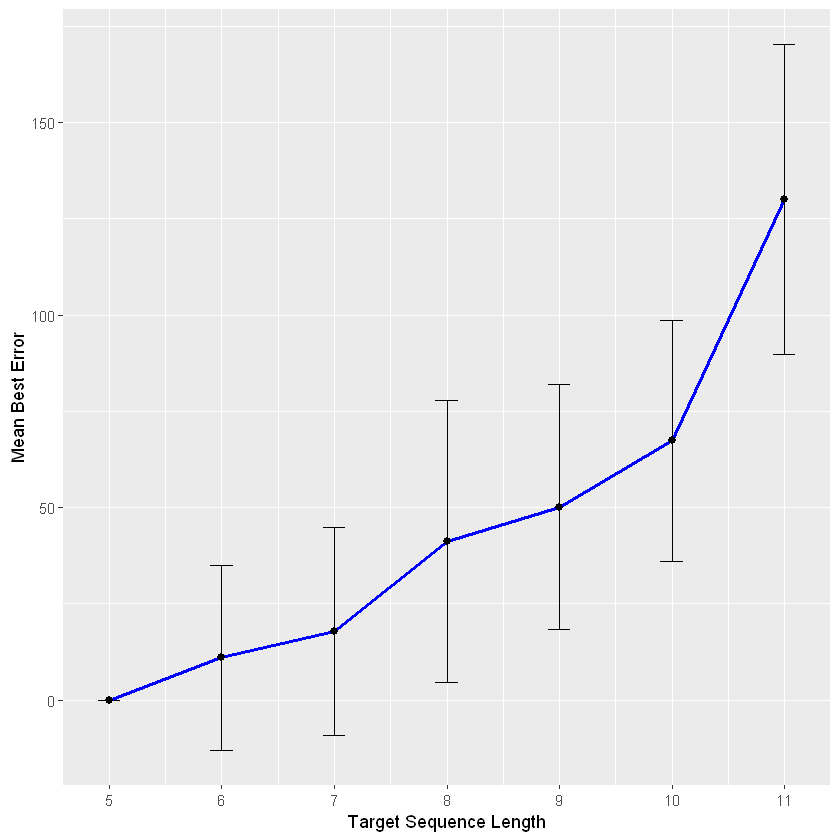

In [4]:
library(ggplot2)
N <- c(5,6,7,8,9,10,11)
MeanBestError <- c(0.0,11.0,17.85,41.2,50.15,67.4,130.1)
STDeV<- c(0.0,47.94788837894741,53.83518830653423, 73.24042599548422, 63.752862680823995, 62.547901643460435,80.4350048175544)
df = data.frame(N, MeanBestError, STDeV )
j<-ggplot(df, aes(x= N, y = MeanBestError)) + 
  geom_errorbar(aes(ymin = MeanBestError-STDeV/2, ymax = MeanBestError+STDeV/2, width = 0.2)) +
  geom_line(color = "blue", size = 1) +
  geom_point(size = 2,) +
  labs(y = "Mean Best Error") +
  scale_x_continuous("Target Sequence Length", labels = as.character(N), breaks = N)
print(j)

Similarly to the paper's results, the MBE goes up as target sequence length increase.
However I noticed here that my measurement of error is different than that of the paper which makes me doubt if I'm coding the FP evaluation correctly.

The large variance could be due to the fact that a smaller number of trials were run(20 instead of 100), the low M value(25) and due to the natrue of randomness.

### Replication of Figure 3 ( in R)

For this graph I parsed the data using a modified version of my evolute function. For each of the 4 lengths I tested, 20 trials were run, at 200 maxgen, and M= 25. The errors are averaged for all generations. 

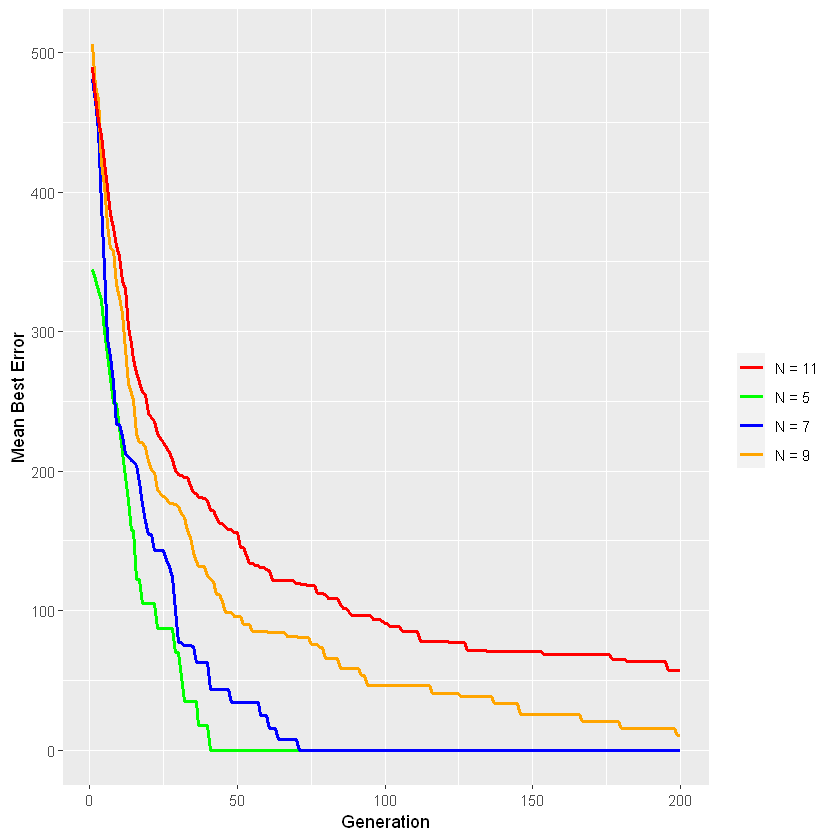

In [3]:
library(ggplot2)
N <- c(5,7,9,11)
gen <- c(1:200)
a5 = c(344.6, 337.2, 329.8, 322.4, 301.2, 283.7, 266.2, 248.7, 248.7, 231.2, 213.7, 196.2, 178.7, 157.5, 157.5, 122.5, 122.5, 105.0, 105.0, 105.0, 105.0, 105.0, 87.5, 87.5, 87.5, 87.5, 87.5, 87.5, 70.0, 70.0, 52.5, 35.0, 35.0, 35.0, 35.0, 35.0, 17.5, 17.5, 17.5, 17.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
a7 = c(480.6, 464.7, 444.1, 390.75, 345.4, 295.35, 282.2, 263.45, 233.2, 233.2, 224.6, 212.6, 210.4, 207.75, 206.7, 203.8, 192.2, 176.15, 164.2, 154.8, 154.8, 143.15, 143.15, 143.15, 143.15, 136.15, 131.7, 123.9, 100.45, 77.4, 77.4, 75.2, 75.2, 75.2, 74.4, 62.6, 62.6, 62.6, 62.6, 62.6, 43.8, 43.8, 43.8, 43.8, 43.8, 43.8, 43.8, 34.4, 34.4, 34.4, 34.4, 34.4, 34.4, 34.4, 34.4, 34.4, 34.4, 25.0, 25.0, 25.0, 15.6, 15.6, 15.6, 7.8, 7.8, 7.8, 7.8, 7.8, 7.8, 7.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
a9 = c(505.95, 476.05, 466.45, 420.7, 405.15, 377.0, 359.4, 358.55, 333.75, 324.65, 312.7, 286.95, 262.65, 255.95, 250.45, 227.05, 220.8, 220.8, 216.7, 206.75, 201.15, 199.25, 187.15, 184.25, 181.75, 180.4, 177.05, 177.05, 176.3, 174.8, 169.5, 167.1, 157.6, 152.5, 141.85, 135.35, 131.35, 131.35, 131.35, 125.45, 123.3, 121.15, 111.75, 111.75, 106.65, 98.55, 98.55, 98.55, 95.5, 95.5, 95.5, 90.3, 90.3, 90.3, 84.9, 84.9, 84.9, 84.9, 84.9, 84.9, 84.2, 84.2, 84.2, 84.2, 84.2, 84.2, 81.2, 81.2, 81.2, 81.2, 80.85, 80.85, 80.85, 80.85, 75.75, 75.75, 75.75, 73.75, 73.7, 65.6, 65.6, 65.6, 65.6, 65.6, 58.35, 58.35, 58.35, 58.35, 58.35, 58.35, 58.35, 53.25, 53.25, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 40.9, 40.9, 40.9, 40.9, 40.9, 40.9, 40.9, 40.9, 40.9, 40.9, 38.75, 38.75, 38.75, 38.75, 38.75, 38.75, 38.75, 38.75, 38.75, 38.75, 38.75, 33.65, 33.65, 33.65, 33.65, 33.65, 33.65, 33.65, 33.65, 33.65, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 25.5, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 20.4, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 15.3, 10.2, 10.2)
a11 = c(489.55, 467.9, 451.35, 440.9, 421.55, 403.35, 384.0, 374.6, 361.45, 354.15, 336.2, 331.3, 303.15, 291.7, 280.2, 270.9, 263.4, 256.5, 254.9, 241.65, 238.35, 235.75, 226.75, 223.55, 220.9, 216.9, 213.65, 208.2, 200.7, 197.85, 197.2, 195.1, 195.1, 189.95, 184.9, 183.9, 181.35, 180.9, 180.05, 179.05, 172.05, 172.05, 166.65, 162.2, 162.2, 160.2, 158.15, 158.15, 156.35, 156.35, 145.25, 145.25, 139.35, 133.65, 133.65, 132.05, 132.05, 130.7, 130.7, 129.15, 128.6, 121.8, 121.8, 121.8, 121.8, 121.4, 121.4, 121.4, 121.4, 119.65, 119.65, 118.55, 118.55, 117.7, 117.7, 117.7, 112.6, 112.6, 112.6, 111.8, 109.05, 109.05, 108.6, 108.6, 104.7, 101.55, 101.55, 98.35, 96.65, 96.65, 96.5, 96.5, 96.5, 96.5, 96.5, 93.6, 93.6, 93.6, 92.15, 90.75, 90.75, 88.9, 88.9, 88.9, 88.9, 84.7, 84.7, 84.7, 84.7, 84.7, 84.7, 78.05, 78.05, 78.05, 78.05, 78.05, 78.05, 78.05, 78.05, 78.05, 78.05, 76.85, 76.85, 76.85, 76.85, 76.85, 76.85, 71.75, 71.75, 71.75, 71.75, 71.75, 71.75, 71.75, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 70.9, 68.85, 68.85, 68.85, 68.85, 68.85, 68.85, 68.85, 68.85, 68.85, 68.85, 68.85, 68.85, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 68.25, 64.65, 64.65, 64.65, 64.65, 64.65, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 63.2, 57.25, 57.25, 57.25, 57.25, 57.25)
df = data.frame(N, gen, a5,a7,a9, a11 )
j<-ggplot(df, aes(x= gen)) + 
  geom_line(aes(y = a5, color = "N = 5"), size = 1) +
  geom_line(aes(y = a7, color = "N = 7"), size = 1)+
  geom_line(aes(y = a9, color = "N = 9"), size = 1)+
  geom_line(aes(y = a11, color = "N = 11"), size = 1)+
  scale_colour_manual("", values = c("N = 5"="green", "N = 7"="blue", "N = 9" = "orange", "N = 11"="red")) +
  labs(x = "Generation", y = "Mean Best Error")
             
print(j)



Again, very similar to the paper's results, sequences of higher length take longer to reach the best solution. Here however the generations before reaching the correct result is much higher has I've set M to be much, much lower. 

I've done some side testings and at least for sequences of length 10, with M = 100 and above. The generation where a perfect solution is found is usually between 10 and 40.

## Discussion (please do not run the code pieces here either)

### Performance

While with this algorithm is is rather difficult to estimate the runtime and space, as both of these performance metrics are heavily based on complete random. The algorithm does have a hard limit which is maxgen, however the M parameter also affects this, as with a smaller M reaching maxgen is a lot easier.
The assumption I will make however is that the algorithm performs in linear time at best as each generation there're more functions to evaluate in the tournament phase(where each of the population member are pitched against 10 randoms). Increasing initial generation size will indeed increase how fast the population grows and how slow the algorithm gets as generations increment.

Unfortunately I cannot run my implementation very well, for a 20 length sequence with M=200, prbsize = 5, on my machine it takes anywhere between 20 minutes and an hour to perfectly solve. Which I assume to be due to the nature of the randomness.

However It could also be my wrong assumption about the "absolute differences" in FPs described in the paper. For my implementation I class key(subsequence) and value(binding strength) differences to be virtually the same. I have tried to penalise key differences harder than value by added 2 errors instead of 1 but this does not seem to make the algorithm faster.

Other optimisation tries I've done by modifying the algorithm include culling the very old generation and keeping the entire population within a set number so that the population list doesn't explode in size and runtime doesn't climb exponentially. However, as I track the min error score of this implementation, it goes down extremely slow and even climb back up in later generations a lot more frequently. 



tcaattgaag


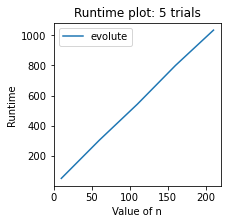

In [7]:
# sequence length
seqlen = 10
# probe size/length
prblen = 5
# threshold under which FP binding efficiency will be ignored/set to 0
# set to the paper's default which is n/2
threshold = prblen // 2

refseq = randomstring(seqlen)
print(refseq)
FPref = generateFP(refseq, prblen)



plotruntimes([lambda n:evolute(FPref,4, 10, n, 1000)],["evolute"],range(10,250,50))


In the paper they described using parameters such as seqlen between 10 and 40 M = 500. maxgen = 1000. However I found with my implementation that 500 is way too high for M. Here I tested the runtime for M at seqlen=10, prb=5. I assumed that it never reached maxgen as i set it to 1000(which is really high for seqlen=10 even for M=50), and the highest generation I've observed for len=10 is around 200. Although, any M value below 50 is rather unreliable for len=10.

This did suprised me that it's linearly improvement as M is low. I initially did this test to try to find an optimal M between 50 and 200, as I found that reducing M can overall, improve performance in some if not most cases.
